# Kredi Riski Sınıflandırması

**Amaç**
Bu projenin amacı, bireyleri bir dizi özellik temelinde "iyi" veya "kötü" kredi riski olarak sınıflandırmaktır. Lojistik Regresyon ve KNN Sınıflandırma modellerini uygulayarak bu sınıflandırmaları gerçekleştirip performansları değerlendirilenecek ve sonuçları karşılaştırılanacaktır.


**Hazırlayan:**

Melike Su Koçyiğit


## EDA - Exploratory Data Analysis

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('final_data.csv')

In [3]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,1,1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,2,2,49,male,1,own,little,NaN,2096,12,education,1
3,3,3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,4,4,53,male,2,free,little,little,4870,24,car,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0.1      1000 non-null   int64 
 1   Unnamed: 0        1000 non-null   int64 
 2   Age               1000 non-null   int64 
 3   Sex               1000 non-null   object
 4   Job               1000 non-null   int64 
 5   Housing           1000 non-null   object
 6   Saving accounts   817 non-null    object
 7   Checking account  606 non-null    object
 8   Credit amount     1000 non-null   int64 
 9   Duration          1000 non-null   int64 
 10  Purpose           1000 non-null   object
 11  Risk              1000 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 93.9+ KB


In [5]:
# Veri setindeki sütun isimlerini görüntüleme
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing',
       'Saving accounts', 'Checking account', 'Credit amount', 'Duration',
       'Purpose', 'Risk'],
      dtype='object')

In [6]:
# Gereksiz sütunları kaldırma 
data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)


In [7]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


In [8]:
# Temel istatistikleri hesaplama ve Değişkenlerin Dağılımları
data.describe()

,Age,Job,Credit amount,Duration,Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000,0.700000
std,11.375469,0.653614,2822.736876,12.058814,0.458487
min,19.000000,0.000000,250.000000,4.000000,0.000000
25%,27.000000,2.000000,1365.500000,12.000000,0.000000
50%,33.000000,2.000000,2319.500000,18.000000,1.000000
75%,42.000000,2.000000,3972.250000,24.000000,1.000000
max,75.000000,3.000000,18424.000000,72.000000,1.000000


## İstatistiksel Özet:

- Age: Ortalama 35.5, minimum 19, maksimum 75
- Credit amount: Ortalama 3271.3, minimum 250, maksimum 18424
- Duration: Ortalama 20.9 ay, minimum 4 ay, maksimum 72 ay
- Risk: %70 iyi kredi riski, %30 kötü kredi riski

In [9]:
# Hedef kolonunda ('iyi' ve 'kötü' kredi riski) oran nasıldır? Veri dengesiz mi?
data['Risk'].value_counts(normalize=True)

1    0.7
0    0.3
Name: Risk, dtype: float64

Bu durum, verinin dengesiz olduğunu gösteriyor çünkü "iyi kredi riski" (1) çok daha yaygın ve "kötü kredi riski" (0) daha az temsil ediliyor. Bu tür veri setlerinde sınıf dengesizliği (class imbalance) olabilir, bu da modelin kötü kredi riskini (0) daha az öğrenmesi veya tahmin etmesi anlamına gelebilir.

In [10]:
#'İyi' ve 'Kötü' kredi riski grupları arasında 'Duration' farklılıkları

duration_good = data[data['Risk'] == 1]['Duration']
duration_bad = data[data['Risk'] == 0]['Duration']

# Temel istatistiklerin hesaplanması
stats_good = duration_good.describe()
stats_bad = duration_bad.describe()

print("İyi Kredi Riski (Risk = 1) - Duration İstatistikleri:")
print(stats_good)

print("\nKötü Kredi Riski (Risk = 0) - Duration İstatistikleri:")
print(stats_bad)


İyi Kredi Riski (Risk = 1) - Duration İstatistikleri:
count    700.000000
mean      19.207143
std       11.079564
min        4.000000
25%       12.000000
50%       18.000000
75%       24.000000
max       60.000000
Name: Duration, dtype: float64

Kötü Kredi Riski (Risk = 0) - Duration İstatistikleri:
count    300.000000
mean      24.860000
std       13.282639
min        6.000000
25%       12.000000
50%       24.000000
75%       36.000000
max       72.000000
Name: Duration, dtype: float64


- Kötü kredi riski grubu, genellikle daha uzun vadeli ve daha değişken kredi sürelerine sahip.

- Kısa vadeli krediler (özellikle 18 ay ve altı), genellikle iyi kredi riski grubunda daha yaygın.

Bu durum, uzun vadeli kredilerin daha yüksek bir riskle ilişkilendirilebileceğini ve kredi verenlerin bu sürelerde daha dikkatli olmaları gerektiğini gösterebilir.


# Veri Görselleştirme 

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


###  Sayısal değişkenler
- Age
- Credit amount
- Duration

## IQR

Veri kümesinde 'Age' (Yaş) sütunundaki aykırı değerleri belirlemek için interquartile range (IQR) yöntemini kullandık. IQR, veri setinin 1. çeyreği (Q1) ile 3. çeyreği (Q3) arasındaki farkı ifade eder ve veri setindeki orta Aykırı değerleri belirlemek için şu adımlar izlendi:

Q1 (1. çeyrek): Veri setindeki verilerin %25'inin altında kalan değer.
Q3 (3. çeyrek): Veri setindeki verilerin %75'inin altında kalan değer.
IQR: Q3 - Q1
Aykırı değerleri belirlemek için alt ve üst sınırları hesapladık:

Alt Sınır: Q1 - 1.5 * IQR
Üst Sınır: Q3 + 1.5 * IQR
Veri setindeki değerler bu sınırların dışında kalıyorsa, aykırı değer olarak kabul edilir.


In [12]:
# IQR kullanarak aykırı değerleri belirleme işlevi
def find_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers, lower_bound, upper_bound


**`1- Age Histogram Grafiği`**



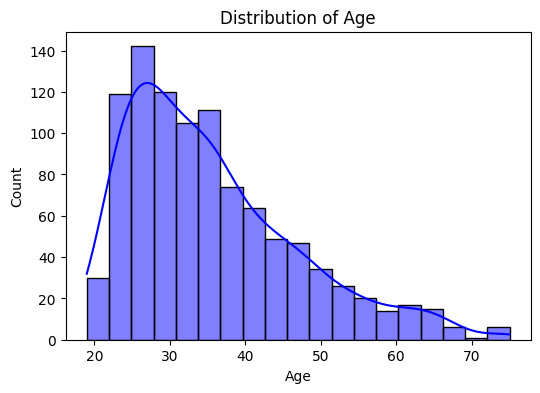

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(data['Age'], kde=True, color='blue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Grafiğin Yorumu
**Dağılımın Genel Yapısı:**

- Age değişkeninin dağılımı sağa çarpıktır. Genç yaşlarda daha fazla veri noktası bulunurken, yaş arttıkça veri noktalarının sayısı azalmaktadır.

**En Yoğun Yaş Aralıkları:**

- En yüksek yoğunlukta veri noktaları, yaklaşık 25-30 yaş aralığındadır.
- 20-40 yaş aralığında yoğun bir veri kümesi bulunmaktadır, bu da bu yaş grubunun veri setinde yoğun olarak temsil edildiğini gösterir.

**Düşük Yoğunlukta Yaş Aralıkları:**

- 50 yaş ve üzerindeki bireylerin sayısı belirgin şekilde azalmaktadır.
- Özellikle 60 yaşın üzerinde veri sayısı oldukça düşüktür.

**KDE Çizgisi (Kernel Density Estimate):**

- Yaş arttıkça yoğunluğun azaldığını gösteren bir eğilim mevcuttur.

**Aykırı Değerler:**

- 20 yaşın altındaki ve 60 yaşın üzerindeki bireyler potansiyel aykırı değerler olarak değerlendirilebilir. Bu yaş aralıklarında veri sayısı oldukça azdır ve veri setinde nadir görülürler.

**Yoğunluk ve Veri Dengesi:**

- Veri setinin büyük bir kısmı 20-50 yaş aralığında yoğunlaşmıştır. Bu, veri setinin yaş dağılımında belirli bir eğilimi olduğunu gösterir.

**Veri Setindeki Eksiklikler:**

-70 yaş ve üzeri bireylerin sayısının çok az olduğu görülmektedir. Bu, veri setinde yaşlı bireylerin yeterince temsil edilmediğini gösterebilir.

In [14]:
# Age Kolonunun Analizi
outliers_age, lower_age, upper_age = find_outliers_iqr(data['Age'])
print("Age Outliers Analysis:")
print(f"Lower Bound: {lower_age}")
print(f"Upper Bound: {upper_age}")
print(f"Number of Outliers: {len(outliers_age)}")

Age Outliers Analysis:
Lower Bound: 4.5
Upper Bound: 64.5
Number of Outliers: 23


**` Age Kutu Grafiği`**


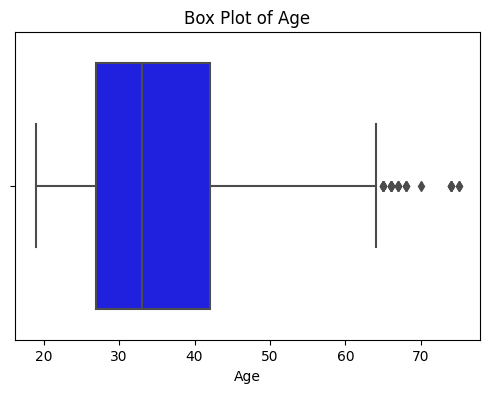

In [15]:
# Figure boyutunu ayarlama
plt.figure(figsize=(6, 4))

# Kutu grafiği çizme
sns.boxplot(x=data['Age'], color='blue')

# Grafik başlığı ve eksen etiketlerini ekleme
plt.title('Box Plot of Age')
plt.xlabel('Age')
plt.show()

###  Grafiğin Yorumu 
**Merkezi Eğilim ve Yayılım:**

- Medyan yaklaşık 30-35 yaş arasındadır.
- Kutunun alt ve üst kenarları, verinin %50'sini temsil eder (Q1 ve Q3).

**İç ve Dış Sınırlar:**

- Çizgiler, minimum ve maksimum değerleri gösterir (aykırı değerler hariç).

**Aykırı Değerler:**

- 60 yaş ve üzerindeki bazı bireyler aykırı değer olarak görülür.

**Veri Yoğunluğu:**

- Verilerin çoğu 20-40 yaş aralığında yoğunlaşmıştır.


**`2- Credit Amount Histogram Grafiği`**

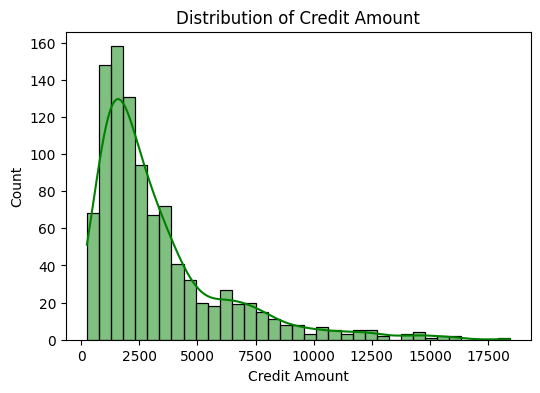

In [16]:
plt.figure(figsize=(6, 4))
sns.histplot(data['Credit amount'], kde=True, color='green')
plt.title('Distribution of Credit Amount')
plt.xlabel('Credit Amount')
plt.ylabel('Count')
plt.show()


### Credit amount Yorumu:

**Dağılım Yapısı:**
- sağa çarpık bir dağılıma sahiptir; düşük kredi miktarları daha yoğundur, yüksek miktarlar ise azalmaktadır.
- Yoğun Kredi Aralıkları: En yoğun veri 2000-3000 aralığında bulunmakta, 0-5000 arasında yoğun bir küme gözlenmektedir.

**Düşük Yoğunluk:**
- 10.000 ve üzeri kredi miktarları nadir olup düşük bir yoğunluk sergilemektedir.

**KDE Çizgisi:**
- Kredi miktarı arttıkça yoğunluk düzenli şekilde azalmaktadır.

**Aykırı Değerler:**
- 10.000 üzerindeki kredi miktarları potansiyel aykırı değer olarak değerlendirilebilir.

**Yoğunluk ve Veri Dengesi:**
- Veri ağırlığı düşük kredi miktarlarına yoğunlaşmıştır.

In [17]:
# Credit amount kolonunun analizi
outliers_credit, lower_credit, upper_credit = find_outliers_iqr(data['Credit amount'])
print("\nCredit Amount Outliers Analysis:")
print(f"Lower Bound: {lower_credit}")
print(f"Upper Bound: {upper_credit}")
print(f"Number of Outliers: {len(outliers_credit)}")


Credit Amount Outliers Analysis:
Lower Bound: -2544.625
Upper Bound: 7882.375
Number of Outliers: 72


Lower Bound'un Negatif olması veri dağılımının asimetrik olmasındandır.

In [18]:
# 'İyi' kredi riski kategorisindeki bireylerin ortalama 'Credit amount' değeri 
mean_credit_good_risk = data[data['Risk'] == 1]['Credit amount'].mean()
mean_credit_good_risk

2985.457142857143

**`3- Duration Histogram Grafiği`**

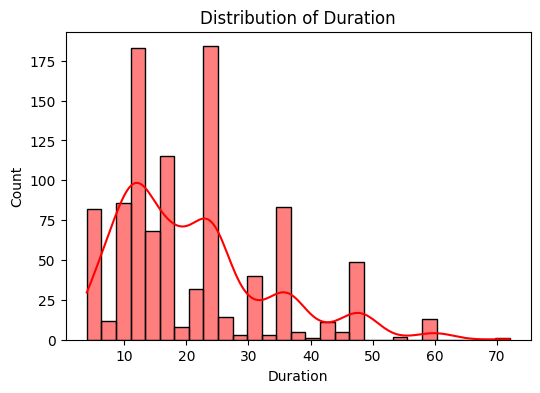

In [19]:
plt.figure(figsize=(6, 4))
sns.histplot(data['Duration'], kde=True, color='red')
plt.title('Distribution of Duration')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.show()

### Grafiğin Yorumu

**Dağılım Yapısı:**
- "Duration" değişkeni sağa çarpık bir dağılıma sahiptir; düşük süreler daha yaygındır, yüksek süreler ise azalmaktadır.
- Yoğun Süre Aralıkları: En yoğun veri 10-20 ay aralığındadır; özellikle 12 ve 18 aylık süreler dikkat çekicidir.

**Düşük Yoğunluk:**
- 40 ay ve üzerindeki sürelerin frekansı oldukça düşüktür.

**KDE Çizgisi:**
- Süre arttıkça yoğunluk genelde azalmaktadır, ancak bazı sürelerde küçük tepe noktaları vardır.

**Aykırı Değerler:**
- 50 ay ve üzerindeki süreler potansiyel aykırı değer olarak değerlendirilebilir.

**Yoğunluk ve Veri Dengesi:**
- Veri çoğunluğu 10-40 ay aralığında yoğunlaşmıştır.

In [20]:
# Duration kolonunun analizi
outliers_duration, lower_duration, upper_duration = find_outliers_iqr(data['Duration'])
print("\nDuration Outliers Analysis:")
print(f"Lower Bound: {lower_duration}")
print(f"Upper Bound: {upper_duration}")
print(f"Number of Outliers: {len(outliers_duration)}")


Duration Outliers Analysis:
Lower Bound: -6.0
Upper Bound: 42.0
Number of Outliers: 70


## Kategorik değişkenler

- Sex
- Housing
- Purpose


**`1- Cinsiyet (Sex) Çubuk Grafiği`**

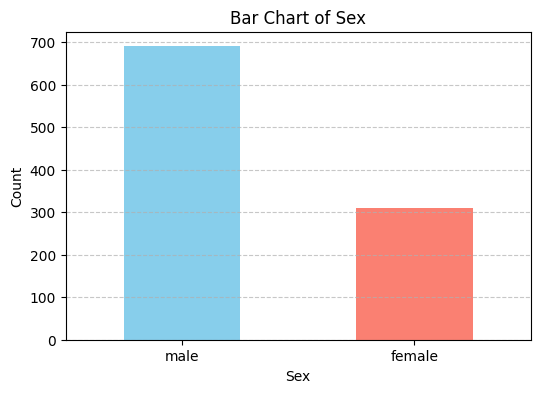

In [21]:
plt.figure(figsize=(6, 4))
data['Sex'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Bar Chart of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)  # This will set the labels to be horizontal
plt.show()




### Grafiğin Yorumlanması

**Sex (Cinsiyet):**

**Dağılım Yapısı:**
- Cinsiyet değişkeninde "male" kategorisi "female" kategorisinden daha fazla bireyi kapsamaktadır.

**Yoğunluk Farkı:**
- Erkek birey sayısı yaklaşık 700 civarında, kadın birey sayısı ise yaklaşık 300 civarındadır.

**Dengesizlik:**
- Veride erkek bireylerin oranı kadınlara kıyasla belirgin şekilde fazladır.

**`2- Konut Durumu (Housing) Çubuk Grafiği`**

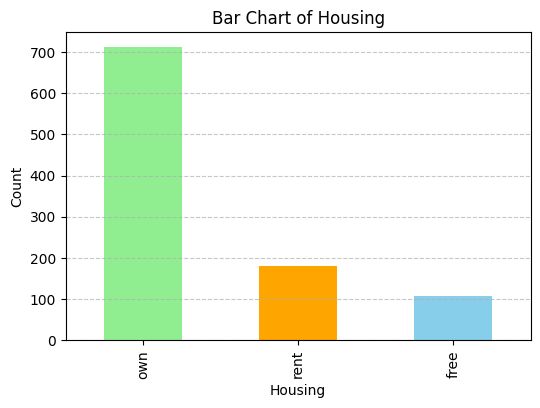

In [22]:
plt.figure(figsize=(6, 4))
data['Housing'].value_counts().plot(kind='bar', color=['lightgreen', 'orange', 'skyblue'])
plt.title('Bar Chart of Housing')
plt.xlabel('Housing')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Grafiğin Yorumlanması

**Housing (Konut Durumu):**

**Dağılım Yapısı:**
- "own" kategorisi (ev sahibi) en yüksek sayıya sahiptir ve yaklaşık 700 bireyi kapsamaktadır.

**Yoğunluk Farkı:**
- "rent" (kiralık) kategorisi yaklaşık 200 bireyi temsil ederken, "free" (ücretsiz) kategorisi yaklaşık 100 bireyi kapsamaktadır.

**Dengesizlik:**
- Veride ev sahipleri belirgin şekilde daha fazla temsil edilmiştir.


In [23]:
#'Free' konut kategorisindeki bireylerin 'Saving accounts' değişkeninin dağılımı
free_housing_saving_accounts = data[data['Housing'] == 'free']['Saving accounts'].value_counts(normalize=True)
free_housing_saving_accounts

little        0.788235
moderate      0.117647
quite rich    0.070588
rich          0.023529
Name: Saving accounts, dtype: float64

**`3- Purpose Çubuk Grafiği`**

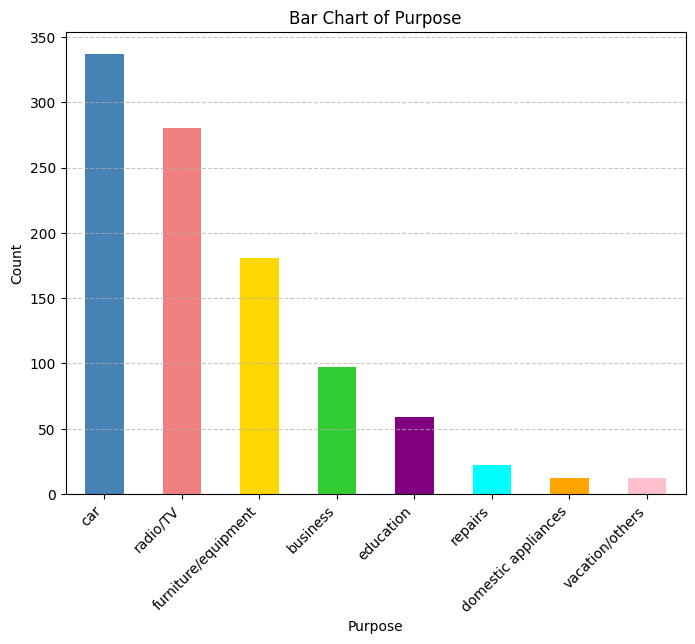

In [24]:
plt.figure(figsize=(8, 6)) 
colors = ['steelblue', 'lightcoral', 'gold', 'limegreen', 'purple', 'cyan', 'orange', 'pink', 'brown'] 
data['Purpose'].value_counts().plot(kind='bar', color=colors)
plt.title('Bar Chart of Purpose')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')  # X eksenindeki yazıları sağa hizalama 
plt.show()



### Grafiğin Yorumlanması
**Dağılım Yapısı:**
- En fazla tercih edilen amaç "car" (araba) olup yaklaşık 350 bireyi kapsamaktadır.

**Yoğunluk Sıralaması:**
- İkinci sırada "radio/TV" (radyo/televizyon) yaklaşık 300 birey ile yer alırken, bunu "furniture/equipment" (mobilya/ekipman) yaklaşık 200 birey ile takip etmektedir.

**Düşük Yoğunluk:**
- "vacation/others" (tatil/diğer) ve "domestic appliances" (ev aletleri) gibi kategoriler çok düşük bir oranda temsil edilmiştir.

**Dengesizlik:**
- "car", "radio/TV" ve "furniture/equipment" amaçları, verinin büyük çoğunluğunu oluşturarak diğer kategorilere göre belirgin bir dengesizlik sergilemektedir.

In [25]:
# Yüksek kredi miktarına sahip bireylerin (75. percentile üzerinde) en sık kullandığı 3 'Purpose' kategorisi 

high_credit = data[data['Credit amount'] > data['Credit amount'].quantile(0.75)]
top_purposes = high_credit['Purpose'].value_counts().head(3)
print(top_purposes)

car         108
radio/TV     39
business     39
Name: Purpose, dtype: int64


In [26]:
# Korelasyon matrisi oluşturalım 
corr_matrix = data.corr(numeric_only=True)

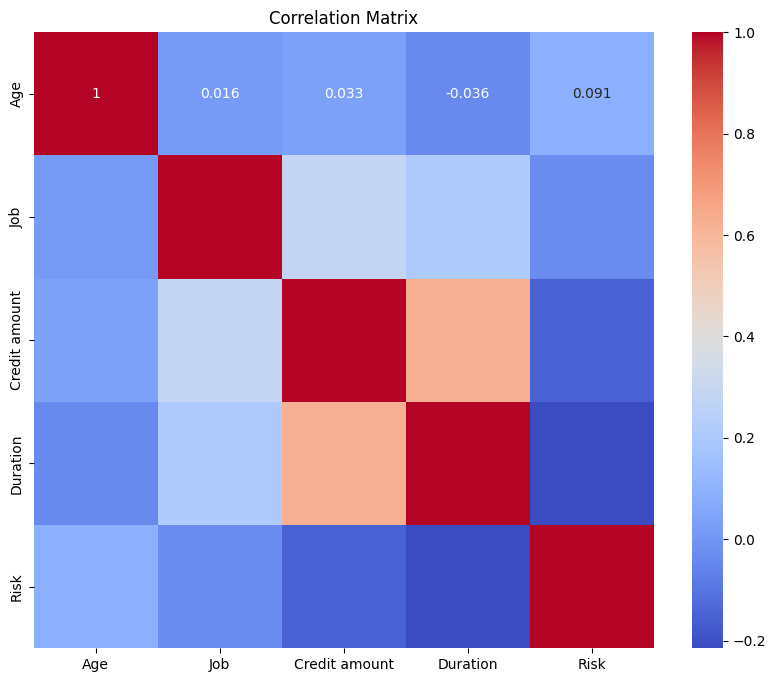

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()


### Matris üzerindeki detaylı analiz

**Age ve diğer değişkenler:**

- "Age" ile diğer değişkenler arasında oldukça düşük korelasyon değerleri mevcut (örneğin, "Job" ile 0.016, "Credit amount" ile 0.033). Bu, yaşın diğer faktörler üzerinde neredeyse hiçbir etkisi olmadığını gösterir.

**Job ve diğer değişkenler:**

- "Job" ile diğer değişkenler arasında da düşük korelasyon gözlenmekte. Bu, iş durumunun ("Job") diğer değişkenler (örneğin kredi miktarı veya süre) üzerinde belirgin bir etkisinin olmadığını gösteriyor.

**Credit amount ve Duration:**

- "Credit amount" ve "Duration" arasında pozitif bir korelasyon gözleniyor (değer 0.8 civarında gibi). Bu, kredi miktarı arttıkça kredi süresinin de arttığını işaret eder. Bu ilişki mantıklı çünkü genelde daha yüksek krediler daha uzun geri ödeme süreleri gerektirir.

**Risk ve diğer değişkenler:**

- "Risk" ile diğer değişkenler arasında belirgin bir korelasyon gözlenmiyor. Bu, risk faktörünün ele alınan değişkenlerden bağımsız olabileceğini veya başka değişkenler tarafından açıklanabileceğini gösterir.

# Veri Temizleme ve Ön İşleme



In [28]:
# Eksik değerleri tespit etme
missing_values = data.isnull().sum()
missing_values

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

### Eksik Değerlerin Ele Alınması:

In [29]:

# Kategorik değişkenlerde eksik değerleri doldurma ve sayısal dönüşüm

account_mapping = {"unknown": 0, "little": 1, "moderate": 2, "rich": 3}

data['Saving accounts'] = data['Saving accounts'].fillna('unknown').map(account_mapping)
data['Checking account'] = data['Checking account'].fillna('unknown').map(account_mapping)

In [30]:
# Sayısal değişkenlerde eksik değerleri medyan ile doldurma
numeric_columns = data.select_dtypes(include='number').columns  # Sayısal kolonları seç
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

data.info() 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   object 
 2   Job               1000 non-null   int64  
 3   Housing           1000 non-null   object 
 4   Saving accounts   1000 non-null   float64
 5   Checking account  1000 non-null   int64  
 6   Credit amount     1000 non-null   int64  
 7   Duration          1000 non-null   int64  
 8   Purpose           1000 non-null   object 
 9   Risk              1000 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 78.3+ KB


In [31]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,0.0,1,1169,6,radio/TV,1
1,22,female,2,own,1.0,2,5951,48,radio/TV,0
2,49,male,1,own,1.0,0,2096,12,education,1
3,45,male,2,free,1.0,1,7882,42,furniture/equipment,1
4,53,male,2,free,1.0,1,4870,24,car,0


### Kategorik Değişkenlerin Kodlanması:

In [32]:
data.dtypes
# burada objectler direkt olarak kategoriktir fakat risk sayısal gibi gözükse de bir kategori belirtir.

Age                   int64
Sex                  object
Job                   int64
Housing              object
Saving accounts     float64
Checking account      int64
Credit amount         int64
Duration              int64
Purpose              object
Risk                  int64
dtype: object

- Sex
- Housing
- Saving accounts: 
- Checking account: 
- Purpose:
- Job:

In [33]:
print(data.columns)

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


In [34]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# 'Purpose' kolonu için one-hot encoding
data = pd.get_dummies(data, columns=['Purpose'], drop_first=True)

# 'Housing' kolonu için one-hot encoding
data = pd.get_dummies(data, columns=['Housing'], drop_first=True)

# 'Sex' kolonu için one-hot encoding
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)

# 'Checking account' kolonu için one-hot encoding
data = pd.get_dummies(data, columns=['Checking account'], drop_first=True)

# 'Saving accounts' kolonu için one-hot encoding
data = pd.get_dummies(data, columns=['Saving accounts'], drop_first=True)

# 'Job' kolonu için one-hot encoding
data = pd.get_dummies(data, columns=['Job'], drop_first=True)


### Özellik Ölçekleme:
**Sayısal değerlerin ölçeklenmesi**
- age
- credit amount
- duration

In [35]:
#Yaş Kategorilerinin Oluşturulması:
bins = [0, 18, 30, 45, 60, 76]  
#Çocuk → 0
#Genç→ 1
#Orta → 2
#Yetişkin → 3
#Yaşlı → 4

labels = [0,1,2,3,4]  

data['Age Category'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

#right false üst sınırın dahil olmaması demektir


In [36]:
data.head()

,Age,Credit amount,Duration,Risk,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Checking account_1,Checking account_2,Checking account_3,Saving accounts_1.0,Saving accounts_2.0,Saving accounts_3.0,Job_1,Job_2,Job_3,Age Category
0,67,1169,6,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,4
1,22,5951,48,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,1
2,49,2096,12,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,3
3,45,7882,42,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,3
4,53,4870,24,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,3


In [37]:
print(data[['Age', 'Age Category']].head())


   Age Age Category
0   67            4
1   22            1
2   49            3
3   45            3
4   53            3


In [38]:
# Sayısal değişkenlerin ölçeklenmesi

scaler = StandardScaler()

data[['Age', 'Credit amount', 'Duration']] = scaler.fit_transform(data[['Age', 'Credit amount', 'Duration']])


In [39]:
data.head()

,Age,Credit amount,Duration,Risk,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Checking account_1,Checking account_2,Checking account_3,Saving accounts_1.0,Saving accounts_2.0,Saving accounts_3.0,Job_1,Job_2,Job_3,Age Category
0,2.766456,-0.745131,-1.236478,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,4
1,-1.191404,0.949817,2.248194,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,1
2,1.183312,-0.416562,-0.738668,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,3
3,0.831502,1.634247,1.750384,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,3
4,1.535122,0.566664,0.256953,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,3


# Özellik Mühendisliği

In [40]:
#Aylık Kredi Miktarının Hesaplanması:
data['Credit per Month'] = data['Credit amount'] / data['Duration']

data['Credit per Month']


0      0.602624
1      0.422480
2      0.563938
3      0.933651
4      2.205319
         ...   
995    0.736681
996    0.275069
997    1.183893
998   -0.252854
999    0.231311
Name: Credit per Month, Length: 1000, dtype: float64

In [41]:
# Korelasyon matrixi yaparak değişkenlerin birbirine olan ilişkisini gözlemleyelim. 

#Yüksek korelasyon, bilgi tekrarına işaret eder. Modelleme sırasında bu tekrar sorun yaratabilir 
correlation_matrix = data.corr(numeric_only=True)

correlation_matrix

,Age,Credit amount,Duration,Risk,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Checking account_1,Checking account_2,Checking account_3,Saving accounts_1.0,Saving accounts_2.0,Saving accounts_3.0,Job_1,Job_2,Job_3,Credit per Month
Age,1.000000,0.032716,-3.613637e-02,0.091127,0.099919,-0.012562,0.060390,-0.127657,-0.046401,0.039567,...,-0.011162,-0.078121,0.037504,-0.029769,-0.075302,0.032007,0.043712,-0.148283,0.127605,-5.087070e-02
Credit amount,0.032716,1.000000,6.249842e-01,-0.154739,0.125575,-0.069268,-0.034796,-0.034037,-0.173203,-0.028875,...,-0.020912,0.119612,-0.100510,-0.070907,0.013546,-0.055542,-0.161757,-0.092636,0.319715,1.399229e-01
Duration,-0.036136,0.624984,1.000000e+00,-0.214927,-0.005320,-0.037212,-0.025450,-0.062804,-0.044319,-0.022549,...,0.022244,0.089452,-0.076455,-0.069732,0.051587,-0.048261,-0.181203,0.055010,0.147515,3.580784e-18
Risk,0.091127,-0.154739,-2.149267e-01,1.000000,-0.022621,-0.008016,-0.049085,-0.020971,0.106922,-0.020828,...,-0.258333,-0.119581,0.044009,-0.130476,-0.022255,0.085749,0.021822,0.013559,-0.040559,-3.927805e-02
Purpose_car,0.099919,0.125575,-5.320362e-03,-0.022621,1.000000,-0.078572,-0.178521,-0.335163,-0.444602,-0.106930,...,0.055317,-0.046053,-0.028134,-0.082723,0.029852,0.018052,-0.007405,-0.097759,0.113935,3.040240e-02
Purpose_domestic appliances,-0.012562,-0.069268,-3.721205e-02,-0.008016,-0.078572,1.000000,-0.027596,-0.051810,-0.068727,-0.016529,...,0.035253,-0.025433,0.009223,0.000156,-0.007131,-0.024747,-0.032144,0.046414,-0.045933,6.047765e-03
Purpose_education,0.060390,-0.034796,-2.545024e-02,-0.049085,-0.178521,-0.027596,1.000000,-0.117714,-0.156151,-0.037555,...,-0.011095,0.001235,0.004943,-0.020642,-0.015038,-0.016518,0.033952,-0.019075,-0.008749,-4.295734e-03
Purpose_furniture/equipment,-0.127657,-0.034037,-6.280367e-02,-0.020971,-0.335163,-0.051810,-0.117714,1.000000,-0.293164,-0.070508,...,0.130479,-0.056750,-0.004308,0.107132,-0.082398,0.028091,-0.020778,0.064393,-0.042335,-1.394142e-02
Purpose_radio/TV,-0.046401,-0.173203,-4.431890e-02,0.106922,-0.444602,-0.068727,-0.156151,-0.293164,1.000000,-0.093531,...,-0.113454,-0.001607,0.058300,0.026067,-0.013482,-0.046259,0.005568,0.085802,-0.096839,-3.957634e-03
Purpose_repairs,0.039567,-0.028875,-2.254938e-02,-0.020828,-0.106930,-0.016529,-0.037555,-0.070508,-0.093531,1.000000,...,-0.015713,0.047382,-0.038890,0.005030,0.016463,0.030106,0.044313,-0.012144,-0.062511,5.484051e-03


In [42]:
# 0.9'un üzerinde korelasyonlar
high_correlation = correlation_matrix[(correlation_matrix > 0.9) & (correlation_matrix < 1.0)]  

In [43]:
high_correlation

,Age,Credit amount,Duration,Risk,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Checking account_1,Checking account_2,Checking account_3,Saving accounts_1.0,Saving accounts_2.0,Saving accounts_3.0,Job_1,Job_2,Job_3,Credit per Month
Age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Purpose_car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Purpose_domestic appliances,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Purpose_education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Purpose_furniture/equipment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Purpose_radio/TV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Purpose_repairs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Bu görüntüde, high_correlation matrisinde yalnızca NaN (boş) değerlerin olduğunu görüntülenmekte. Bu, veri kümemde hiçbir özelliğin korelasyonunun 0.9’dan büyük olmadığı anlamına gelir. 



**Çıkarım:**

- Verimdeki özellikler birbirinden bağımsız bir şekilde iyi dağılmıştır. Hiçbir iki değişken arasında yüksek düzeyde ilişki olmadığı için, veri temizleme aşamasında bu bağlamda bir çıkarma işlemi yapmam gerekmez.
- Bu matris, özellikler arasında düşük ilişkiler olduğunu (genellikle 0’a yakın değerler) ve bunların modelin performansı için problem yaratmayacağını gösterir.

 # Model Uygulaması

## Lojistik Regresyon Modeli

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [45]:
# Özellikler ve hedef değişkeni belirleme
X = data.drop('Risk', axis=1)
y = data['Risk']


In [46]:
# Veri bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
X_train.shape

(800, 24)

In [48]:
X_test.shape

(200, 24)

In [49]:
# Lojistik Regresyon Modeli
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [50]:
# Lojistik Regresyon Tahminleri
y_pred = log_reg.predict(X_test)


In [51]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1])

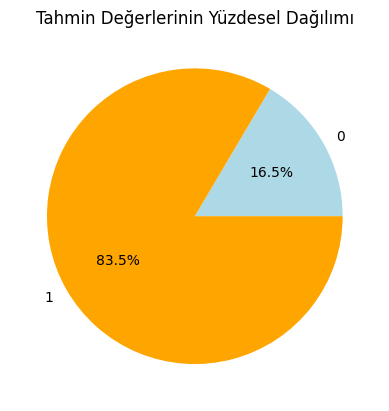

In [52]:
plt.pie([sum(y_pred == 0), sum(y_pred == 1)], labels=['0', '1'], autopct='%1.1f%%', colors=['lightblue', 'orange'])
plt.title('Tahmin Değerlerinin Yüzdesel Dağılımı')
plt.show()


In [53]:
# Model performansını değerlendirme
accuracy_log_reg = accuracy_score(y_test, y_pred)
precision_log_reg = precision_score(y_test, y_pred)
recall_log_reg = recall_score(y_test, y_pred)
f1_log_reg = f1_score(y_test, y_pred)

print("Accuracy:", accuracy_log_reg)
print("Precision:", precision_log_reg)
print("Recall:", recall_log_reg)
print("F1-Skoru:", f1_log_reg)


Accuracy: 0.75
Precision: 0.7724550898203593
Recall: 0.9148936170212766
F1-Skoru: 0.8376623376623377


## En İyi "k" Değeri ile KNN Sınıflandırması ve Değerlendirme

In [54]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np


In [55]:
# En iyi "k" değerini bulmak için hiperparametre optimizasyonu
k_degerleri = range(1, 31)
cv_skorlari = []

for k in k_degerleri:
    knn = KNeighborsClassifier(n_neighbors=k)
    skorlar = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_skorlari.append(skorlar.mean())

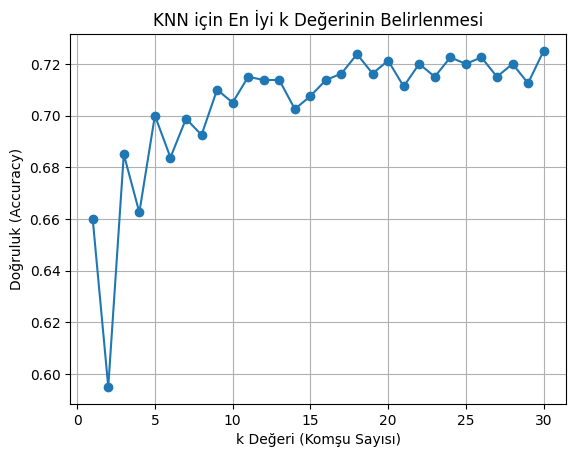

In [56]:
# Çizgi grafiği ile görselleştirme
plt.plot(k_degerleri, cv_skorlari, marker='o', linestyle='-')
plt.title('KNN için En İyi k Değerinin Belirlenmesi')
plt.xlabel('k Değeri (Komşu Sayısı)')
plt.ylabel('Doğruluk (Accuracy)')
plt.grid()
plt.show()

In [57]:
# En iyi "k" değeri
en_iyi_k = k_degerleri[cv_skorlari.index(max(cv_skorlari))]
print(f"En iyi k değeri: {en_iyi_k}")

En iyi k değeri: 30


In [58]:
# En iyi "k" değeri ile modeli eğitme
knn = KNeighborsClassifier(n_neighbors=en_iyi_k)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=30)

In [59]:
# Tahminlerde bulunma
y_pred_knn = knn.predict(X_test)

In [60]:
y_pred_knn

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

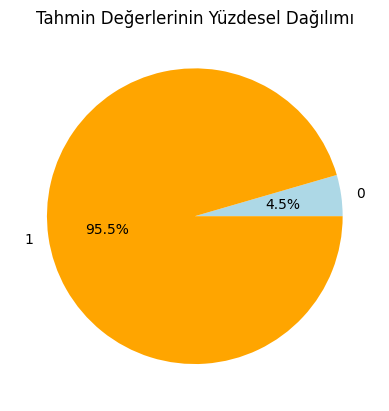

In [61]:
plt.pie([sum(y_pred_knn == 0), sum(y_pred_knn == 1)], labels=['0', '1'], autopct='%1.1f%%', colors=['lightblue', 'orange'])
plt.title('Tahmin Değerlerinin Yüzdesel Dağılımı')
plt.show()

In [62]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print(f'Doğruluk (KNN): {accuracy_knn}')
print(f'Kesinlik (KNN): {precision_knn}')
print(f'Duyarlılık (KNN): {recall_knn}')
print(f'F1-Skoru (KNN): {f1_knn}')

Doğruluk (KNN): 0.75
Kesinlik (KNN): 0.7382198952879581
Duyarlılık (KNN): 1.0
F1-Skoru (KNN): 0.8493975903614458


# Model Değerlendirmesi

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
print("Lojistik Regresyon - Karışıklık Matrisi")
confusion_matrix(y_test, y_pred)


Lojistik Regresyon - Karışıklık Matrisi


array([[ 21,  38],
       [ 12, 129]])

- True Negatives (0,0): 21
- False Positives (0,1): 38
- False Negatives (1,0): 12
- True Positives (1,1): 129

In [65]:
print("KNN - Karışıklık Matrisi")
confusion_matrix(y_test, y_pred_knn)

KNN - Karışıklık Matrisi


array([[  9,  50],
       [  0, 141]])

- True Negatives (0,0): 9
- False Positives (0,1): 50
- False Negatives (1,0): 0
- True Positives (1,1): 141


## Karışıklık Matrisiyle Genel Karşılaştırma

**Avantajlar:**

- Lojistik Regresyon:

Sınıf 0 (negatif sınıf) örneklerinde daha iyi doğruluk sağlıyor (True Negatives daha yüksek, False Positives daha düşük).
Daha dengeli bir performans sergiliyor.

- KNN:

Sınıf 1 (pozitif sınıf) örneklerinde mükemmel duyarlılık (False Negatives: 0).
Daha fazla doğru pozitif sınıflandırma yapıyor (True Positives: 141).

**Dezavantajlar:**

- Lojistik Regresyon:
Sınıf 1 (pozitif sınıf) örneklerinde False Negatives (yanlış negatif) oranı daha yüksek.

- KNN:
Sınıf 0 (negatif sınıf) örneklerinde ciddi hatalar yapıyor (False Positives: 50, True Negatives: 9).

**Sonuç:**
Karışıklık matrisindeki analizler Lojistik Regresyon'un genel kullanımda daha dengeli ve istikrarlı bir model olduğunu gösteriyor.


In [66]:
from sklearn.metrics import classification_report

# Lojistik Regresyon için
print("Lojistik Regresyon Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))


Lojistik Regresyon Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.64      0.36      0.46        59
           1       0.77      0.91      0.84       141

    accuracy                           0.75       200
   macro avg       0.70      0.64      0.65       200
weighted avg       0.73      0.75      0.73       200



### Lojistik Regresyon Sonuçları:

**Sınıf 0 (Negative) Performansı:**
- Precision: 0.64
- Recall: 0.36 (Düşük duyarlılık, yani sınıf 0'ı ayırt etmekte zorlanıyor)
- F1-Score: 0.46

**Sınıf 1 (Positive) Performansı:**

- Precision: 0.77
- Recall: 0.91 (Sınıf 1 için yüksek duyarlılık)
- F1-Score: 0.84

**Genel Performans:**
- Accuracy: 75%
- Macro Avg F1-Score: 0.65 
- Weighted Avg F1-Score: 0.73




In [67]:
# KNN için
print("KNN Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_knn))

KNN Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26        59
           1       0.74      1.00      0.85       141

    accuracy                           0.75       200
   macro avg       0.87      0.58      0.56       200
weighted avg       0.82      0.75      0.68       200



### KNN Sonuçları:

**Sınıf 0 (Negative) Performansı:**

- Precision: 1.00 (Hiç yanlış pozitif yok, ancak bu yanıltıcı olabilir)
- Recall: 0.15 (Çok düşük, çoğu sınıf 0 örneğini kaçırıyor)
- F1-Score: 0.26

**Sınıf 1 (Positive) Performansı:**

- Precision: 0.74
- Recall: 1.00 (Hiç sınıf 1 örneğini kaçırmıyor)
- F1-Score: 0.85

**Genel Performans:** 
- Accuracy: 75%
- Macro Avg F1-Score: 0.56 (Sınıflar arasında büyük bir dengesizlik var)
- Weighted Avg F1-Score: 0.68

**KNN, sınıf 1 için yüksek performans gösterirken, sınıf 0'ı neredeyse tamamen ihmal ediyor. Bu nedenle sınıflar arasındaki dengesizlik daha belirgin.**



## Karşılaştırma:

**Doğruluk (Accuracy):**

- Her iki modelin doğruluk oranı %75 olarak eşit.

**Kesinlik (Precision):**

- Lojistik Regresyon: %70 (macro)
- KNN: %87 (macro)
Sınıf 0: %100
Sınıf 1: %74

- KNN modelinin sınıf 0'daki yüksek kesinliği, sınıf 0'ı tamamen sınıflandırma eksikliğinden kaynaklanabilir.

**Duyarlılık (Recall):**

- Lojistik Regresyon’un macro duyarlılığı %64, KNN’ninki ise %58.
- KNN modelinde sınıf 1’in duyarlılığı yüksekken (%100), sınıf 0’da düşük bir değer (%15) var. Lojistik Regresyon’da ise sınıflar arasında daha dengeli.

**F1-Score:**
- Lojistik Regresyon’un F1-Skoru (macro): %65, KNN’nin ise %56



### Hangi Model Daha İyi?

**Dengeli Performans Gerekiyorsa:**

- Lojistik Regresyon, tüm metriklerde dengeli bir sonuç verdiği için genel olarak daha uygun görünüyor. Duyarlılık ve kesinlik oranlarının makul bir şekilde eşit olması, sınıflar arası dengeyi daha iyi sağlıyor.

**Sınıf 1'in Kritik Olduğu Durumlarda:**

- Eğer sınıf 1’in (örneğin yüksek riskli bir durumun) tüm pozitif örneklerinin doğru tespit edilmesi gerekiyorsa, KNN’nin sınıf 1 için duyarlılığı (%100) büyük bir avantaj sunabilir.

**Sınıf 0 İçin Yüksek Doğruluk Gerekiyorsa:**

- KNN modeli, sınıf 0 için %100 kesinlik sağlayarak bu sınıfa odaklanan senaryolarda tercih edilebilir.

## Sonuç: 

Lojistik Regresyon, genellikle daha dengeli bir performans sağladığı için çoğu senaryo için daha iyi bir seçimdir. Ancak, hangi modelin daha iyi olduğu problemin gereksinimlerine ve hangi hataların daha kritik olduğuna bağlıdır. Örneğin:

- Sınıf 1'i yanlış sınıflandırmanın maliyeti yüksekse → KNN tercih edilebilir.
- Dengeli bir performans istiyorsak → Lojistik Regresyon daha uygundur. 